# Reimplementation of _Topic Modeling with Wasserstein Autoencoders_ by Feng Nan et al. (2019)

#### Group Members: Aryaan Khan, Yuhang Cui, and Raymond Lee

### Import Libraries

In [ ]:
!pip install torch matplotlib nltk scikit-learn spacy

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import re
import nltk
import torch
import pprint
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.stem import WordNetLemmatizer
from torch.distributions import Dirichlet
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Pytorch version is: ", torch.__version__)
print("You are using: ", device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Pytorch version is:  2.2.1+cu121
You are using:  cuda


In [ ]:
!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 12.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
stop_words = set(spacy.load('en_core_web_trf').Defaults.stop_words)
all_words = set(spacy.load('en_core_web_trf').vocab.strings)

### Load the Dataset

In [ ]:
# Load the 20 Newsgroups dataset
# Temporarily bugged on Google Collab: Use Pickle
categories = None
data = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

# Accessing the text data
texts = data.data

### Preprocess the Data

In [ ]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z'\s]", ' ', text, re.I|re.A)

    # Tokenization
    tokens = word_tokenize(text)

    # Removing stopwords and non-english words
    tokens = [token for token in tokens if (token not in stop_words) and (token in all_words)]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Removing stopwords and non-english words
    tokens = [token for token in tokens if (token not in stop_words) and (token in all_words)]

    # Re-create document from tokens
    return ' '.join(tokens)

In [ ]:
len(texts)

18846

In [ ]:
# Apply preprocessing to each document in the dataset
processed_texts = [preprocess_text(text) for text in texts]

# Example of a processed text
print(processed_texts[:10])

["sure bashers pen fan pretty confused lack kind post recent pen massacre devil actually bit puzzled bit relieved going end non ' relief bit praise pen man killing devil worse thought showed better regular season stats lot fo fun watch playoff bowman let lot fun couple game pen going beat pulp jersey disappointed islander lose final regular season game pen rule", 'brother market high performance video card support local bus mb ram suggestion idea diamond stealth pro local bus orchid ati graphic ultra pro high performance card post email thank matt', 'finally said dream mediterranean new area greater year like holocaust july usa sweden april cold changed calendar mentioned true let true shall woman child going pay price raped killed tortured armenian called geneva convention forgot armenian fight forgot killing torture turk time swedish worker lie regional killer like person shoot policy l confused search turkish plane know talking turkey government announced giving weapon armenia start

In [ ]:
# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
tfidf_matrix = vectorizer.fit_transform(processed_texts)

# Review the shape of the TF-IDF matrix
print(tfidf_matrix.shape)


(18846, 10000)


### Define an Encoder and Decoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_topics):
        super(Encoder, self).__init__()
        # MLP with one hidden layer
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_topics)

    def forward(self, w):
        # Apply softmax to output layer to get topic distribution theta
        theta = F.softmax(self.fc2(F.relu(self.fc1(w))), dim=1)
        return theta


class Decoder(nn.Module):
    def __init__(self, num_topics, vocab_size):
        super(Decoder, self).__init__()
        # Beta is the matrix of topic-word vectors (num_topics x vocab_size)
        self.beta = nn.Parameter(torch.randn(num_topics, vocab_size))
        # Bias term
        self.bias = nn.Parameter(torch.randn(vocab_size))

    def forward(self, theta):
        # Reconstruction of bag-of-words representation
        logit = F.softmax(torch.matmul(theta, self.beta) + self.bias, dim=1)
        return logit


### Define the Wasserstein Autoencoder Model

In [ ]:
class WAE(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_topics):
        super(WAE, self).__init__()
        self.encoder = Encoder(vocab_size, hidden_dim, num_topics)
        self.decoder = Decoder(num_topics, vocab_size)

    def forward(self, w):
        theta = self.encoder(w)
        recon = self.decoder(theta)
        return recon, theta

def loss_function(w, recon_w):
    # Negative cross-entropy loss
    return -torch.sum(w * torch.log(recon_w + 1e-10), dim=1).mean()

### Train the WAE Model

In [ ]:
# Function to compute MMD loss
def compute_mmd_loss(theta, prior, kernel):
    n_samples = theta.size(0)
    true_samples = prior.sample((n_samples,))

    xx = kernel(theta, theta).mean()
    yy = kernel(true_samples, true_samples).mean()
    zz = kernel(theta, true_samples).mean()

    return xx + yy - 2 * zz

# Kernel function for MMD
def mmd_kernel(theta, theta_prime, eps=1e-7):
    # Ensure the inputs are on the correct device (theta is assumed to be on the correct device)
    theta_prime = theta_prime.to(theta.device)

    # Compute the cosine similarity and ensure it is in the range [-1, 1] for numerical stability
    cosine_similarity = torch.sum(torch.sqrt(theta + eps) * torch.sqrt(theta_prime + eps), dim=1)
    cosine_similarity = torch.clamp(cosine_similarity, -1 + eps, 1 - eps)

    # Compute the kernel function
    kernel_value = torch.exp(-torch.arccos(cosine_similarity) ** 2)

    return kernel_value


# Function to add noise to the encoder output
def add_noise_to_theta(theta, alpha, concentration):
    noise = Dirichlet(concentration).sample((theta.size(0),)).to(device)
    return (1 - alpha) * theta + alpha * noise

# Modify the training loop to include MMD loss and noise
def train(model, data_loader, optimizer, alpha, concentration, epochs=5):
    model.train()
    prior = Dirichlet(concentration)
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data,) in enumerate(data_loader):
            optimizer.zero_grad()
            theta = model.encoder(data)
            theta_noise = add_noise_to_theta(theta, alpha, concentration)
            recon = model.decoder(theta_noise)

            recon_loss = loss_function(data, recon)
            mmd_loss = compute_mmd_loss(theta, prior, mmd_kernel)
            loss = recon_loss + mmd_loss  # Combine the reconstruction and MMD losses

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}')

In [ ]:
# Normalize the TF-IDF matrix
normalized_tfidf_matrix = normalize(tfidf_matrix)

# Convert the normalized TF-IDF matrix to a dense PyTorch tensor
tfidf_tensor = torch.from_numpy(normalized_tfidf_matrix.toarray()).float().to(device)  # Send to device

# Create a dataset and dataloader
dataset = TensorDataset(tfidf_tensor)  # tfidf_tensor is already on the device
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the WAE model and send it to the device
vocab_size = tfidf_tensor.shape[1]  # Number of features in the TF-IDF representation
hidden_dim = 100  # Example value, you may want to tune this
num_topics = 20  # Assuming we want to discover 20 topics
wae = WAE(vocab_size, hidden_dim, num_topics).to(device)  # Send to device

# Choose an optimizer
optimizer = torch.optim.Adam(wae.parameters(), betas=(0.99,0.99),lr=0.002)

# Example alpha and Dirichlet concentration parameter for noise, send to device
alpha = 0.5
concentration = torch.ones(num_topics, device=device)  # Send to device

In [ ]:
%%time
# Assuming that the train function correctly handles the device,
# you can now call the train function with the new parameters:
train(wae, data_loader, optimizer, alpha, concentration, epochs=500)

Epoch 1/500, Average Loss: 1.4238960483101262
Epoch 2/500, Average Loss: 1.3315622585158584
Epoch 3/500, Average Loss: 1.3097654792213218
Epoch 4/500, Average Loss: 1.3052934002727001
Epoch 5/500, Average Loss: 1.303663690796352
Epoch 6/500, Average Loss: 1.3024353811496208
Epoch 7/500, Average Loss: 1.301041945471931
Epoch 8/500, Average Loss: 1.2993663887834392
Epoch 9/500, Average Loss: 1.2971678801330806
Epoch 10/500, Average Loss: 1.2943855245364113
Epoch 11/500, Average Loss: 1.2916233495303202
Epoch 12/500, Average Loss: 1.2884108070657725
Epoch 13/500, Average Loss: 1.2851207795497859
Epoch 14/500, Average Loss: 1.28207157964503
Epoch 15/500, Average Loss: 1.2787743251338628
Epoch 16/500, Average Loss: 1.2755997415992164
Epoch 17/500, Average Loss: 1.2726421843007227
Epoch 18/500, Average Loss: 1.2695152845831037
Epoch 19/500, Average Loss: 1.2665402436603044
Epoch 20/500, Average Loss: 1.263732874936186
Epoch 21/500, Average Loss: 1.2609621767758388
Epoch 22/500, Average Loss:

In [ ]:
# Save the model if needed
# Note: When loading the model state, you'll need to map the location to the device
torch.save(wae.state_dict(), 'wasserstein_ae.pth')

### Evaluate the Model

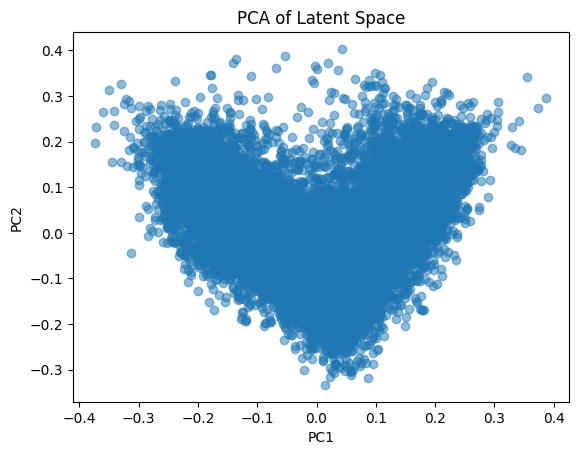

In [ ]:
wae.load_state_dict(torch.load('wasserstein_ae.pth'))

# Assuming 'model' is already trained and 'tfidf_matrix' is available
wae.eval()

# Extract the latent representations
latent_variables = []
for i in range(tfidf_matrix.shape[0]):
    data_point = torch.tensor(tfidf_matrix[i].toarray()).float().to(device)
    _, z = wae(data_point)
    latent_variables.append(z.detach().cpu().numpy())

latent_variables = np.array(latent_variables).squeeze()

# Use PCA for dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_latent = pca.fit_transform(latent_variables)

# Plot
plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], alpha=0.5)
plt.title('PCA of Latent Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
%%time
# Extract the latent representations
latent_variables = []
for i in range(tfidf_matrix.shape[0]):
    data_point = torch.tensor(tfidf_matrix[i].toarray()).float().to(device)
    _, z = wae(data_point)
    latent_variables.append(z.detach().cpu().numpy())
latent_variables = np.array(latent_variables).squeeze()

kmeans = KMeans(n_clusters=num_topics, random_state=0, n_init='auto').fit(latent_variables)
labels = kmeans.labels_

CPU times: user 12.1 s, sys: 144 ms, total: 12.2 s
Wall time: 12.2 s


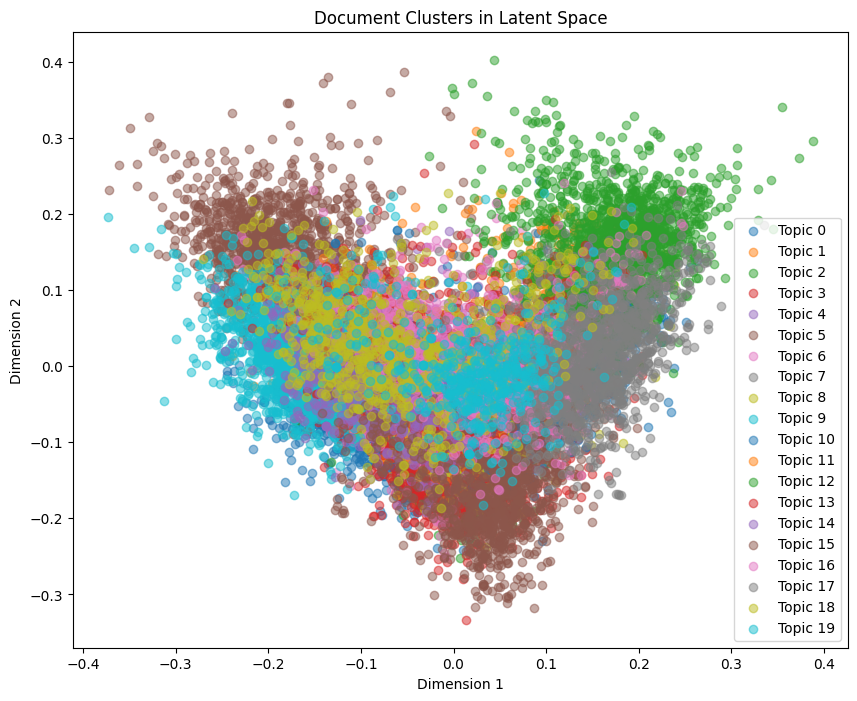

In [ ]:
# Plot PCA for topics
plt.figure(figsize=(10, 8))
for i in range(num_topics):
    plt.scatter(reduced_latent[labels == i, 0], reduced_latent[labels == i, 1], label=f'Topic {i}', alpha=0.5)
plt.title('Document Clusters in Latent Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [ ]:
#Get top words for each topic
words = vectorizer.get_feature_names_out()  # For sklearn versions 0.24 and later use get_feature_names_out()

top_words_per_topic = []
for i in range(num_topics):  # 'num_topics' is the number of clusters you decided in KMeans
    # Calculate mean TF-IDF score for words in documents of each cluster
    topic_mean = np.array(tfidf_matrix[labels == i].mean(axis=0)).flatten()

    # Get indices of top 10 words for this topic
    top_indices = topic_mean.argsort()[-30:][::-1]  # Change 10 to another number if you want more or fewer words
    top_features = [words[index] for index in top_indices]
    top_words_per_topic.append(top_features)

# Example output
print("Top words per topic:")
for i, words in enumerate(top_words_per_topic):
    print(f"Topic {i}: {words}")

Top words per topic:
Topic 0: ['sale', 'offer', 'shipping', 'price', 'condition', 'sell', 'new', 'email', 'asking', 'interested', 'mail', 'game', 'manual', 'cd', 'drive', 'excellent', 'brand', 'best', 'disk', 'like', 'selling', 'box', 'old', 'original', 'thanks', 'reply', 'car', 'year', 'contact', 'obo']
Topic 1: ['monitor', 'thanks', 'price', 'know', 'car', 'like', 'good', 'new', 'buy', 'looking', 'apple', 'model', 'mail', 'think', 'mac', 'info', 'hp', 'heard', 'anybody', 'buying', 'experience', 'computer', 'card', 'hi', 'color', 'advance', 'quality', 'use', 'printer', 'question']
Topic 2: ['game', 'year', 'baseball', 'player', 'team', 'pitcher', 'hit', 'run', 'ball', 'think', 'season', 'hitter', 'pitch', 'time', 'win', 'pitching', 'good', 'fan', 'play', 'league', 'stats', 'better', 'base', 'brave', 'inning', 'career', 'hitting', 'yankee', 'batting', 'like']
Topic 3: ['bike', 'car', 'ride', 'like', 'road', 'dod', 'engine', 'motorcycle', 'tire', 'mile', 'rear', 'riding', 'speed', 'good

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# First, get the beta matrix from the decoder (topic-word distribution)
beta = wae.decoder.beta.cpu().detach().numpy()

# Extract the top words for each topic
top_n = 30  # Number of top terms to extract for each topic
top_words = np.array(vectorizer.get_feature_names_out())
top_words_topic = np.argsort(beta, axis=1)[:, -top_n:][::-1]
topics = [top_words[topic_idxs] for topic_idxs in top_words_topic]

# Convert the tokenized documents to a Gensim dictionary
tokenized_docs = [doc.split() for doc in processed_texts]
gensim_dictionary = Dictionary(tokenized_docs)

# Convert tokenized documents into a document-term matrix for Gensim
corpus = [gensim_dictionary.doc2bow(doc) for doc in tokenized_docs]

# Compute Coherence Score using Gensim's CoherenceModel
coherence_model = CoherenceModel(topics=topics, texts=tokenized_docs, corpus=corpus, dictionary=gensim_dictionary, coherence='c_npmi')
coherence_score = coherence_model.get_coherence()

print(f'Coherence Score: {np.absolute(coherence_score)}')

Coherence Score: 0.20192466506876533


In [ ]:
from collections import Counter

def topic_uniqueness_score(topics):
    # Flatten the list of top_words_per_topic
    all_words = [word for topic in topics for word in topic]
    word_counts = Counter(all_words)

    # Calculate the uniqueness score
    uniqueness_scores = []
    for i in range(len(topics)):
        uniqueness_scores.append(sum([1 / word_counts[word] for word in topics[i]])/len(topics[i]))
    return uniqueness_scores

In [ ]:
# Cluster the latent space to identify topics
print(np.mean(topic_uniqueness_score(topics)))

0.9766666666666668


In [ ]:
# Print top words for topics
pprint.pp(topics)

[array(['fielding', 'williams', 'sox', 'sandberg', 'clutch', 'henderson',
       'mcgwire', 'bond', 'nolan', 'yankee', 'pitched', 'runner',
       'clemens', 'mound', 'catcher', 'baseball', 'obp', 'pitching',
       'baseman', 'rbi', 'pitch', 'gant', 'mattingly', 'stephenson',
       'inning', 'kingman', 'batting', 'hitter', 'batter', 'pitcher'],
      dtype=object),
 array(['mahan', 'photoshop', 'aura', 'corona', 'visualization', 'tt',
       'alexia', 'adobe', 'huntsville', 'humor', 'modem', 'uy',
       'animation', 'shearson', 'max', 'quicktime', 'trinitron', 'gif',
       'irony', 'intergraph', '145', 'geode', 'photography', 'bps',
       'projector', 'iff', 'jennifer', 'nux', 'manchester', 'lilley'],
      dtype=object),
 array(['bel', 'waco', 'illegal', 'rifle', 'spence', 'militia', 'dayton',
       'sue', 'sheriff', 'valentine', 'panicking', 'garrett', 'handgun',
       'diesel', 'odometer', 'raid', 'ammunition', 'stockpiling',
       'weapon', 'grenade', 'snapped', 'concealed'

In [ ]:
from sklearn.manifold import TSNE

# Get TSNE transformation
tsne = TSNE(n_components=2,random_state=0)
latent_tsne = tsne.fit_transform(latent_variables)
tsne.kl_divergence_

2.3274590969085693

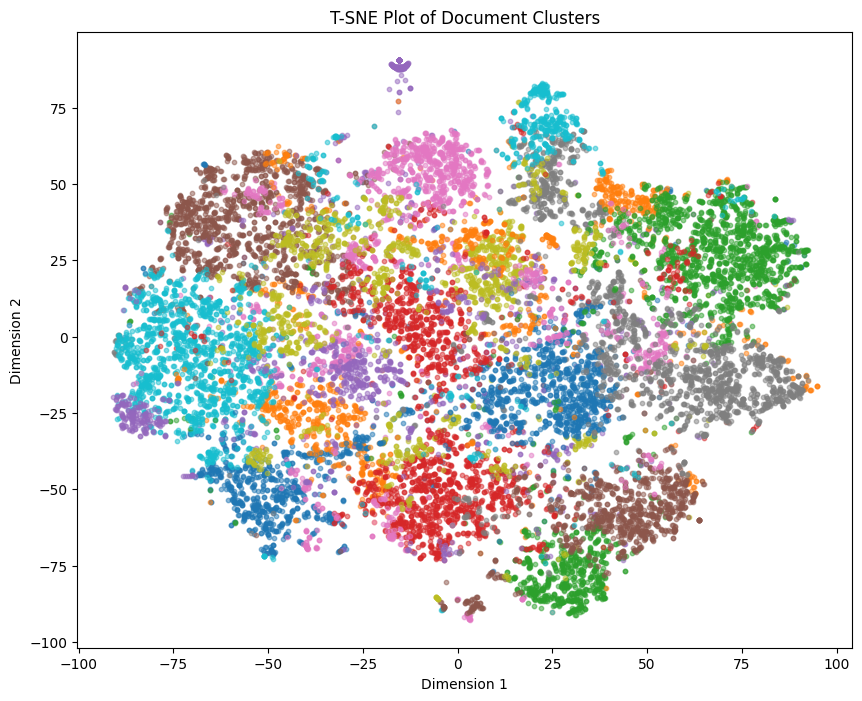

In [ ]:
# Plot T-SNE
plt.figure(figsize=(10, 8))
for i in range(num_topics):
    plt.scatter(latent_tsne[labels == i, 0], latent_tsne[labels == i, 1], label=f'Topic {i}', alpha=0.5, s=10)
plt.title('T-SNE Plot of Document Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

X = normalized_tfidf_matrix.toarray()
lda = LatentDirichletAllocation(n_components=20,random_state=0,max_iter=2000)

In [ ]:
%%time
lda.fit(X)

CPU times: user 2h 56min 28s, sys: 2h 1min 26s, total: 4h 57min 54s
Wall time: 2h 57min 8s


LatentDirichletAllocation(max_iter=2000, n_components=20, random_state=0)

In [ ]:
import pickle

with open('lda.pickle','wb+') as fp:
  pickle.dump(lda,fp)

In [ ]:
with open('lda.pickle','rb') as fp:
  lda = pickle.load(fp)

In [ ]:
%%time
y_hat = lda.transform(X)
y_class = np.argmax(y_hat,axis=1)

CPU times: user 4.46 s, sys: 3.08 s, total: 7.53 s
Wall time: 4.07 s


In [ ]:
tsne2 = TSNE(n_components=2,random_state=0)
latent_tsne2 = tsne2.fit_transform(y_hat)
tsne2.kl_divergence_

1.142471432685852

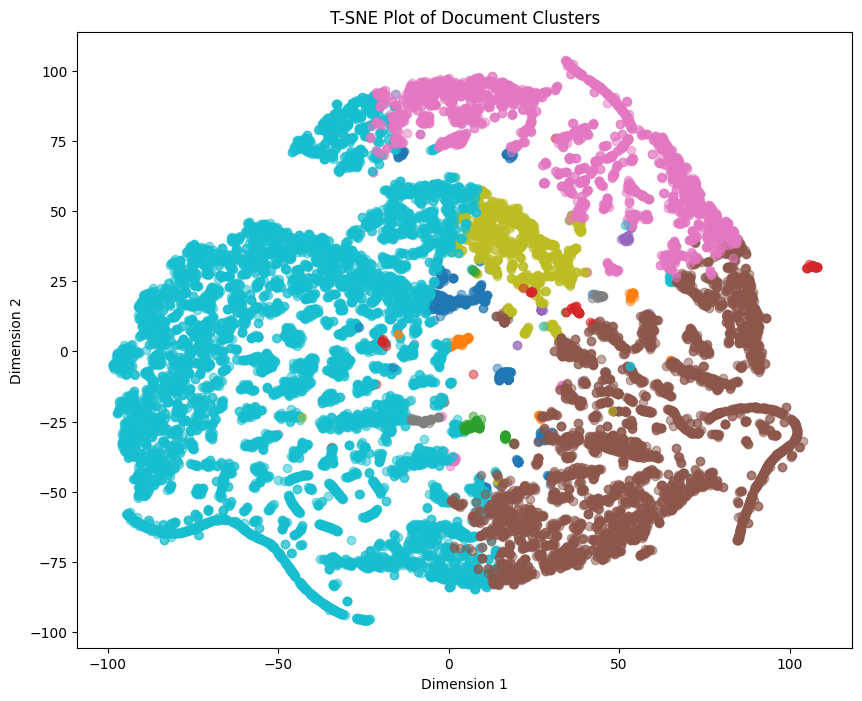

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(num_topics):
    plt.scatter(latent_tsne2[y_class == i, 0], latent_tsne2[y_class == i, 1], label=f'Topic {i}', alpha=0.5)
plt.title('T-SNE Plot of Document Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
topic_words = []
for topic, comp in enumerate(lda.components_):
    # for the n-dimensional array "arr":
    # argsort() returns a ranked n-dimensional array of arr, call it "ranked_array"
    # which contains the indices that would sort arr in a descending fashion
    # for the ith element in ranked_array, ranked_array[i] represents the index of the
    # element in arr that should be at the ith index in ranked_array
    # ex. arr = [3,7,1,0,3,6]
    # np.argsort(arr) -> [3, 2, 0, 4, 5, 1]
    # word_idx contains the indices in "topic" of the top num_top_words most relevant
    # to a given topic ... it is sorted ascending to begin with and then reversed (desc. now)
    word_idx = np.argsort(comp)[::-1][:top_n]

    # store the words most relevant to the topic
    topic_words.append([top_words[i] for i in word_idx])
topic_words = np.array(topic_words)
topic_words

array([['armenian', 'israel', 'arab', 'israeli', 'space', 'war',
        'muslim', 'jew', 'jewish', 'launch', 'orbit', 'nazi', 'turkish',
        'palestinian', 'killing', 'shuttle', 'mission', 'moon',
        'satellite', 'nasa', 'west', 'university', 'killed', 'city',
        'army', 'rocket', 'russian', 'land', 'york', 'east'],
       ['detector', 'radar', 'virginia', 'australia', 'smiley', 'upenn',
        'keith', 'let', 'eng', 'legend', 'arch', 'weaver', 'corvette',
        'jason', 'ivy', 'sa', 'keller', 'smoker', 'cooper', 'cr',
        'curve', 'istanbul', 'bath', 'bedroom', 'kelley', 'br', 'sac',
        'ft', 'markus', 'shielding'],
       ['movie', 'seizure', 'photography', 'corn', 'taurus', 'jeep',
        'spice', 'egg', 'reactor', 'plant', 'steam', 'bastard', 'water',
        'tower', 'hank', 'nickname', 'dlc', 'passion', 'film', 'belongs',
        'cooling', 'mask', 'mattingly', 'rice', 'realise', 'uranium',
        'corona', 'evangelical', 'parish', 'ham'],
       ['bm

In [ ]:
# Compute Coherence Score using Gensim's CoherenceModel
coherence_model = CoherenceModel(topics=topic_words, texts=tokenized_docs, corpus=corpus, dictionary=gensim_dictionary, coherence='c_npmi')
coherence_score = coherence_model.get_coherence()

print(f'Coherence Score: {np.absolute(coherence_score)}')

Coherence Score: 0.15480031896840157


In [ ]:
print(np.mean(topic_uniqueness_score(topic_words)))

0.9683333333333334


In [ ]:
with open('vectorizer.pickle','wb+') as fp:
  pickle.dump(vectorizer,fp)
with open('tfidf_matrix.pickle','wb+') as fp:
  pickle.dump(tfidf_matrix,fp)